In [32]:
# Imports and Mounting Drive
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dset
from IPython.display import display
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
# Utility Functions
def display_image(img, title=None):
    np_img = img.numpy()
    plt.axis("off")
    if title:
        plt.title(title, fontsize=12, fontweight="bold")
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

def plot_loss(steps, losses):
    plt.figure(figsize=(10, 5))
    plt.plot(steps, losses, color="purple", linewidth=2)
    plt.xlabel("Iteration")
    plt.ylabel("Contrastive Loss")
    plt.title("Loss over Training Iterations")
    plt.grid()
    plt.show()

In [34]:
# Configuration
class Config:
    training_dir = "/content/drive/My Drive/data/faces/training/"
    testing_dir = "/content/drive/My Drive/data/faces/testing/"
    batch_size = 64
    epochs = 100


In [35]:
# Dataset
folder_dataset = dset.ImageFolder(root=Config.training_dir)


In [36]:
class SiameseDataset(Dataset):
    def __init__(self, imageFolderDataset, transform=None, invert=True):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.invert = invert

    def __getitem__(self, idx):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        same_class = random.randint(0, 1)

        while True:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)
            if (img0_tuple[1] == img1_tuple[1]) == same_class:
                break

        img0, img1 = Image.open(img0_tuple[0]), Image.open(img1_tuple[0])
        img0, img1 = img0.convert("L"), img1.convert("L")

        if self.invert:
            img0, img1 = ImageOps.invert(img0), ImageOps.invert(img1)

        if self.transform:
            img0, img1 = self.transform(img0), self.transform(img1)

        return img0, img1, torch.tensor([float(img1_tuple[1] != img0_tuple[1])], dtype=torch.float32)

    def __len__(self):
        return len(self.imageFolderDataset.imgs)


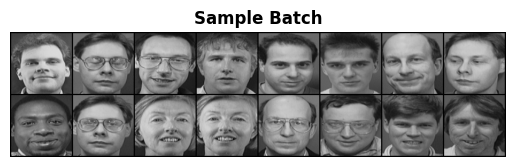

Labels for each pair in the batch (0 for same class, 1 for different class):
[[1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]


In [37]:
# Apply Transformations
transform = transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()])
siamese_dataset = SiameseDataset(folder_dataset, transform=transform, invert=False)

# Visualize Batch
vis_dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=4, batch_size=8)
data_iter = iter(vis_dataloader)
sample_batch = next(data_iter)

# Concatenate images for visualization
concatenated = torch.cat((sample_batch[0], sample_batch[1]), 0)
display_image(torchvision.utils.make_grid(concatenated), title="Sample Batch")

# Print labels for each pair (0 for same class, 1 for different class)
labels = sample_batch[2]  # Labels indicating whether pairs are similar or dissimilar
print("Labels for each pair in the batch (0 for same class, 1 for different class):")
print(labels.tolist())


In [38]:
# Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),

            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size()[0], -1)
        x = self.fc_layers(x)
        #x = F.normalize(x, p=2, dim=1)  # Apply normalization here
        return x

    def forward(self, input1, input2):
        output1, output2 = self.forward_once(input1), self.forward_once(input2)
        return output1, output2


In [39]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.5):  # Increase margin to encourage larger distances
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        l1_distance = F.l1_loss(output1, output2, reduction='none').sum(dim=1, keepdim=True)
        loss = torch.mean((1 - label) * torch.pow(l1_distance, 2) +
                          label * torch.pow(torch.clamp(self.margin - l1_distance, min=0.0), 2))
        return loss

Epoch [0/50], Step [0/6], Loss: 2.7108
Epoch [1/50], Step [0/6], Loss: 6.1486
Epoch [2/50], Step [0/6], Loss: 6.7562
Epoch [3/50], Step [0/6], Loss: 2.9375
Epoch [4/50], Step [0/6], Loss: 1.8607
Epoch [5/50], Step [0/6], Loss: 2.1345
Epoch [6/50], Step [0/6], Loss: 3.7475
Epoch [7/50], Step [0/6], Loss: 1.3468
Epoch [8/50], Step [0/6], Loss: 1.3356
Epoch [9/50], Step [0/6], Loss: 0.8930
Epoch [10/50], Step [0/6], Loss: 0.7140
Epoch [11/50], Step [0/6], Loss: 0.8856
Epoch [12/50], Step [0/6], Loss: 0.5441
Epoch [13/50], Step [0/6], Loss: 0.5450
Epoch [14/50], Step [0/6], Loss: 0.4760
Epoch [15/50], Step [0/6], Loss: 0.5327
Epoch [16/50], Step [0/6], Loss: 0.3287
Epoch [17/50], Step [0/6], Loss: 0.3745
Epoch [18/50], Step [0/6], Loss: 0.2213
Epoch [19/50], Step [0/6], Loss: 0.2557
Epoch [20/50], Step [0/6], Loss: 0.2026
Epoch [21/50], Step [0/6], Loss: 0.2082
Epoch [22/50], Step [0/6], Loss: 0.2665
Epoch [23/50], Step [0/6], Loss: 0.1756
Epoch [24/50], Step [0/6], Loss: 0.1984
Epoch [25/

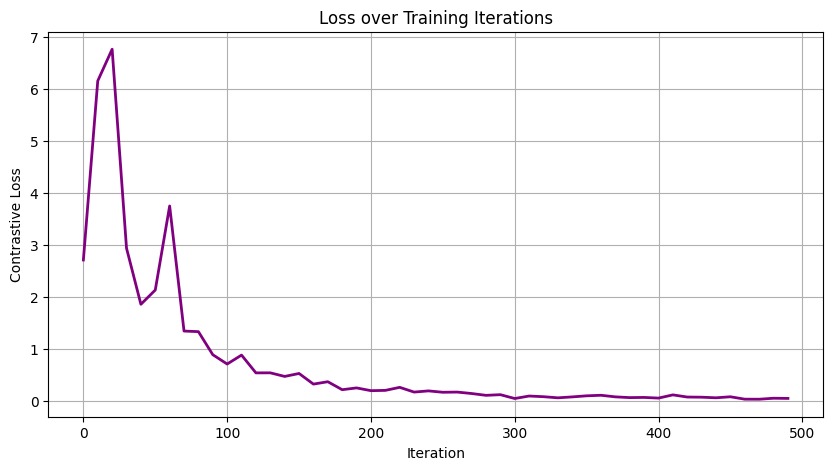

In [41]:
# Training
train_loader = DataLoader(siamese_dataset, shuffle=True, num_workers=4, batch_size=Config.batch_size)
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

steps, losses, step_count = [], [], 0
for epoch in range(50):
    for i, (img0, img1, label) in enumerate(train_loader):
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        loss = criterion(output1, output2, label)
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Epoch [{epoch}/{50}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}")
            steps.append(step_count)
            losses.append(loss.item())
            step_count += 10

plot_loss(steps, losses)

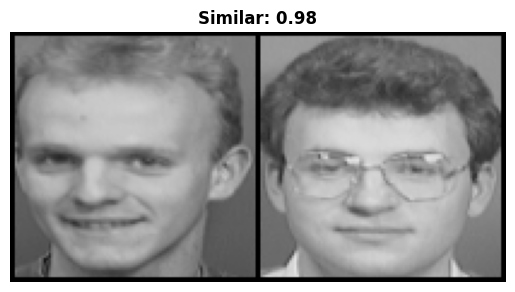

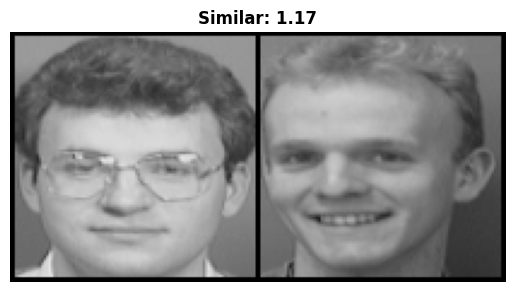

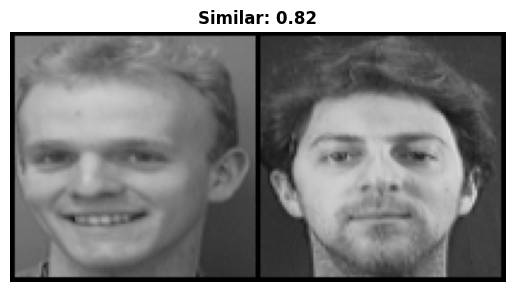

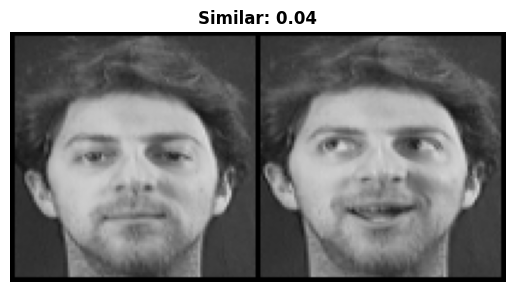

In [51]:
# Set up the test dataset and dataloader
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_test_dataset = SiameseDataset(imageFolderDataset=folder_dataset_test,
                                      transform=transforms.Compose([
                                          transforms.Resize((100, 100)),
                                          transforms.ToTensor()
                                      ]),
                                      invert=False)

test_dataloader = DataLoader(siamese_test_dataset, num_workers=4, batch_size=1, shuffle=True)
test_iter = iter(test_dataloader)

# Initial image for comparison
initial_image, _, _ = next(test_iter)

# Loop to compare the initial image with others
for i in range(4):
    _, comparison_image, label = next(test_iter)
    concatenated_images = torch.cat((initial_image, comparison_image), 0)

    # Get network outputs
    output_initial, output_comparison = net(initial_image.cuda(), comparison_image.cuda())

    # Calculate L1 distance
    l1_distance = F.l1_loss(output_initial, output_comparison).item()

    # Display concatenated images with the L1 distance score
    display_image(torchvision.utils.make_grid(concatenated_images), f"Similar: {l1_distance:.2f}")

    # Update the initial image to the current comparison image for the next iteration
    initial_image = comparison_image
